In [124]:
using PyPlot
using Optim

In [125]:
# Convert an Float32 rbg image to Float64 grayscale image
function convert_to_grayscale(I::Array{Float32,3})
    I=convert(Array{Float64,3}, I)
    I_gray = 0.2989*I[:,:,1] + 0.5870*I[:,:,2] + 0.1140*I[:,:,3]
    return I_gray::Array{Float64,2}
end

convert_to_grayscale (generic function with 1 method)

In [126]:
# Load Tsukuba disparity dataset and convert it to grayscale
function load_data()
    i0_path = string(@__DIR__,"/i0.png")
    i0 = imread(i0_path)
    i0 = convert_to_grayscale(i0)
    i1_path = string(@__DIR__,"/i1.png")
    i1 = imread(i1_path)
    i1 = convert_to_grayscale(i1)
    gt_path = string(@__DIR__,"/gt.png")
    gt64 = convert(Array{Float64,2}, imread(gt_path)*255)

    @assert maximum(gt64) <= 16
    return i0::Array{Float64,2}, i1::Array{Float64,2}, gt64::Array{Float64,2}
end

load_data (generic function with 1 method)

In [127]:
# Robust loss function returning function value and gradient
function robust_func(x::Float64,alpha::Float64,c::Float64)
    if alpha == 2.0
        value = 0.5*(x/c)^2
        gradient = x/(c^2)
    elseif alpha == 0.0
        value = log(0.5*(x/c)^2 + 1)
        gradient = (2*x)/(x^2 + 2*c^2)
    # TODO: case alpha == -inf ?
    else
        value = abs(alpha-2)/alpha * ((x/c)^2/abs(alpha-2) + 1)^(alpha/2)-1
        gradient = x/(c^2) * ((x/c)^2/abs(alpha-2) + 1)^(alpha/2 - 1)
    end
    # print("\nValue of robust func: ", value)
    return value::Float64,gradient::Float64
end

robust_func (generic function with 1 method)

In [128]:
function prior(x::Array{Float64,2})
    alpha = 2.0
    c = 1.0
    prior = 1
    grad_prior = zeros(size(x))
    for i =1:size(x)[1]-1
        for j=1:size(x)[2]-1
            d1 = x[i,j]-x[i+1,j]
            d2 = x[i,j]-x[i,j+1]
            prior *= robust_func(d1, alpha, c)[1]*robust_func(d2, alpha, c)[1]
            grad = 1
            if i+1 <= size(x)[1]
                grad *= robust_func(x[i,j]-x[i+1,j], alpha, c)[2]
            end
            if i-1 >= 1
                grad *= robust_func(x[i-1,j]-x[i,j], alpha, c)[2]
            end
            if j+1 <= size(x)[2]
                grad *= robust_func(x[i,j]-x[i,j+1], alpha, c)[2]
            end
            if j-1 >= 1
                grad *= robust_func(x[i,j-1]-x[i,j], alpha, c)[2]
            end
            grad_prior[i,j] = grad
        end
    end
    # TODO: Normalization
    return prior, grad_prior
end

prior (generic function with 1 method)

In [129]:
function likelihood(x::Array{Float64, 2}, im0::Array{Float64, 2}, im1::Array{Float64, 2})
    lh = 1
    lh_grad = zeros(size(x))
    # TODO
    return lh, lh_grad 
end

likelihood (generic function with 1 method)

In [130]:
function posterior(x::Array{Float64, 2}, im0::Array{Float64, 2}, im1::Array{Float64, 2})
    # TODO
    return post, post_grad
end

posterior (generic function with 1 method)

In [131]:
function stereo(x::Array{Float64, 2}, im0::Array{Float64, 2}, im1::Array{Float64, 2})
    # TODO: Run Optim algorithm on posterior
    return solution
end

stereo (generic function with 1 method)

In [132]:
function problem4()
    #  Up to you...
    im0, im1, gt = load_data()
    figure()
    imshow(gt, "gray")
    show()
    print("GT: ",size(gt))
    print("\nPrior (GT): ", prior(gt)[1])
    print("\nGrad Prior (GT): ",size(prior(gt)[2]))

    # TODO: pyramid
end

problem4 (generic function with 1 method)

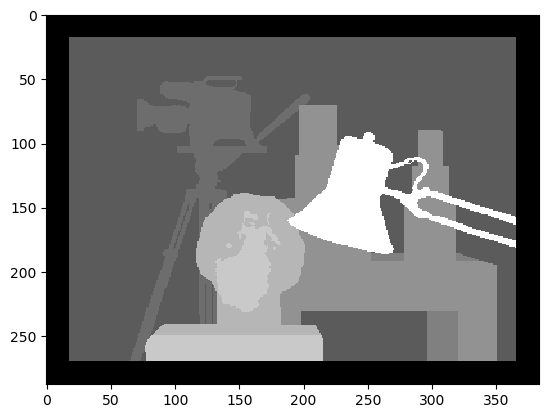

GT: (288, 384)
Prior (GT): 0.0
Grad Prior (GT): (288, 384)

In [133]:
problem4()